# KEN4157 - Reinforcement Learning - Cliff Walking Gymnasium
If you opened this notebook in Google Colab, we recommend to start by saving a copy of the notebook in your own Google Drive, such that you can save any of your changes and experiments.

## Installing & Importing Modules
We will start by installing importing some modules that will likely be useful for your assignment(s). This includes [Gymnasium](https://gymnasium.farama.org/), which is a framework containing many popular RL environments (a successor to the original Gym API from OpenAI).

In [22]:
 # !pip install gymnasium

import gymnasium as gym
import itertools
import math
import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
import numpy as np
import seaborn as sns

from tqdm import tqdm

# Make plots look nice
sns.set()
sns.set_context("notebook")
sns.set_style("whitegrid")

## Setting up the Cliff Walking Environment
Here, we'll set up the Cliff Walking environment, and have a look at how to interact with it according to the Gym API.

**Optional**:
- For a description and documentation of the environment, see: https://gymnasium.farama.org/environments/toy_text/cliff_walking/
- For the implementation of the environment, see: https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/toy_text/cliffwalking.py

In [23]:
env = gym.make('CliffWalking-v0')

action_space = env.action_space
obs_space = env.observation_space
print(f"Action space: {action_space}")
print(f"Observation space: {obs_space}")

# We'll define a few strings here, because proper names are sometimes nicer
# to work with (print) than arbitrary indices
ACTION_NAMES = ["Move Up", "Move Right", "Move Down", "Move Left"]

print(f"There are {action_space.n} different actions in this environment.")
for i in range(action_space.n):
  print(f"Action {i} = {ACTION_NAMES[i]}")
print(f"There are {obs_space.n} discrete states in this environment.")

Action space: Discrete(4)
Observation space: Discrete(48)
There are 4 different actions in this environment.
Action 0 = Move Up
Action 1 = Move Right
Action 2 = Move Down
Action 3 = Move Left
There are 48 discrete states in this environment.


## Visualisation Code
Some functions here that let us nicely visualise Q-value tables for the Cliff Walking environment. No need to touch any of this, but you should run the code block, such that you can use the functions later on.

In [24]:
# Thanks to: https://stackoverflow.com/a/66050636/6735980
def triangulation_for_triheatmap(num_cols, num_rows):
    xv, yv = np.meshgrid(np.arange(-0.5, num_cols), np.arange(-0.5, num_rows))  # vertices of the little squares
    xc, yc = np.meshgrid(np.arange(0, num_cols), np.arange(0, num_rows))  # centers of the little squares
    x = np.concatenate([xv.ravel(), xc.ravel()])
    y = np.concatenate([yv.ravel(), yc.ravel()])
    cstart = (num_cols + 1) * (num_rows + 1)  # indices of the centers

    trianglesN = [(i + j * (num_cols + 1), i + 1 + j * (num_cols + 1), cstart + i + j * num_cols)
                  for j in range(num_rows) for i in range(num_cols)]
    trianglesE = [(i + 1 + j * (num_cols + 1), i + 1 + (j + 1) * (num_cols + 1), cstart + i + j * num_cols)
                  for j in range(num_rows) for i in range(num_cols)]
    trianglesS = [(i + 1 + (j + 1) * (num_cols + 1), i + (j + 1) * (num_cols + 1), cstart + i + j * num_cols)
                  for j in range(num_rows) for i in range(num_cols)]
    trianglesW = [(i + (j + 1) * (num_cols + 1), i + j * (num_cols + 1), cstart + i + j * num_cols)
                  for j in range(num_rows) for i in range(num_cols)]
    return [Triangulation(x, y, triangles) for triangles in [trianglesN, trianglesE, trianglesS, trianglesW]]

# Thanks to: https://stackoverflow.com/a/66050636/6735980
def create_qvals_heatmap(q_vals_up, q_vals_right, q_vals_down, q_vals_left):
    NUM_COLS = 12
    NUM_ROWS = 4

    values = [q_vals_up , q_vals_right, q_vals_down, q_vals_left]
    triangul = triangulation_for_triheatmap(NUM_COLS, NUM_ROWS)
    fig, ax = plt.subplots()

    imgs = [ax.tripcolor(t, val.ravel(), cmap='RdYlGn',
                        norm=colors.SymLogNorm(linthresh=20.0, linscale=1.0,
                                               vmin=np.min(values),
                                               vmax=np.max(values), base=10)
                        )
            for t, val in zip(triangul, values)]
    cbar = fig.colorbar(imgs[0] , ax=ax)

    ax.set_xticks(range(NUM_COLS))
    ax.set_yticks(range(NUM_ROWS))
    ax.invert_yaxis()
    ax.margins(x=0, y=0)
    ax.set_aspect('equal', 'box')  # square cells
    plt.tight_layout()
    plt.show()

def plot_returns_per_episode(returns_per_episode):
    fig, ax = plt.subplots()
    plt.plot([episode for episode in range(len(returns_per_episode))], returns_per_episode, label="Returns per Episode")
    ax.set_xlabel("Episode")
    ax.set_ylabel(f"Returns")
    ax.legend()
    plt.show()
    

## Random Value Function & Policy
In the below code block, we'll:
- fill up a Q(s, a) table with completely random numbers
- run through a bunch of steps with a random policy
- demonstrate how the above functions can be used to visualise this random Q-table and policy

Afterwards, you can implement your own (non-random) algorithms and use the plotting functions in the same way.

100%|██████████| 100000/100000 [00:04<00:00, 24214.57it/s]


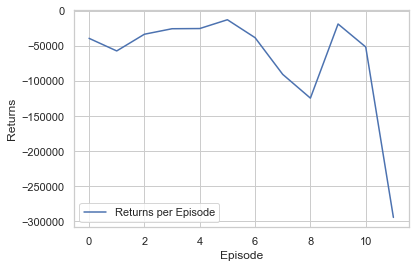

C:\Users\m-m20\AppData\Local\Temp\ipykernel_15712\2346382942.py:34: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(imgs[0] , ax=ax)


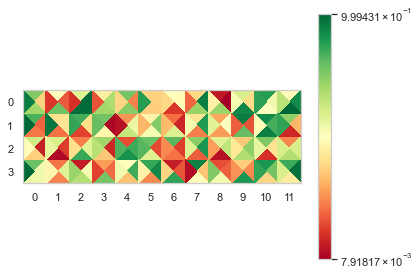

In [25]:
random_q_table = np.random.random((obs_space.n, action_space.n))
returns_per_episode = []

observation, info = env.reset()
current_episode_returns = 0.0

for step in tqdm(range(100_000)):
    action = action_space.sample()

    new_obs, reward, terminated, truncated, info = env.step(action)
    current_episode_returns = current_episode_returns + reward

    if terminated or truncated:
        # episode ended: store data and reset to new episode
        returns_per_episode.append(current_episode_returns)
        current_episode_returns = 0.0
        observation, info = env.reset()
    else:
        observation = new_obs

# Plot returns we got for each completed episode
plot_returns_per_episode(returns_per_episode)

# Plot heatmap from our Q-table (which in this case is just random numbers)
q_vals_up = random_q_table[:, 0]
q_vals_right = random_q_table[:, 1]
q_vals_down = random_q_table[:, 2]
q_vals_left = random_q_table[:, 3]
create_qvals_heatmap(q_vals_up, q_vals_right, q_vals_down, q_vals_left)

## Your Code
Your own code should probably go below here!

# Q learning

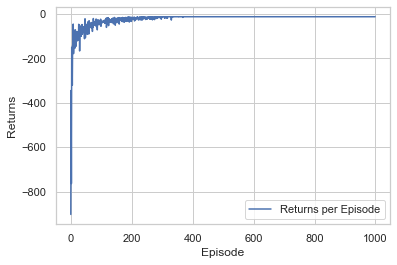

C:\Users\m-m20\AppData\Local\Temp\ipykernel_15712\2346382942.py:34: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(imgs[0] , ax=ax)


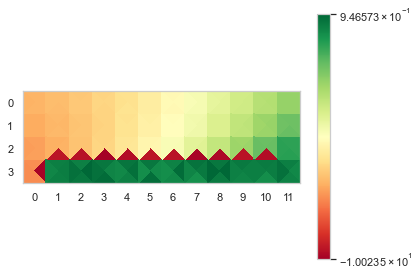

In [26]:
# Parameters for Q-learning
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
num_episodes = 1000  # Number of episodes for training

# Function to choose an action always exploiting the learned values
def choose_action(state):
    return np.argmax(random_q_table[state])  # Exploit learned values

# Q-learning algorithm
random_q_table = np.random.random((obs_space.n, action_space.n))
returns_per_episode = []  # To store total rewards per episode

for episode in range(num_episodes):
    state, _ = env.reset()
    done = False
    total_rewards = 0

    while not done:
        action = choose_action(state)
        next_state, reward, done, truncated, info = env.step(action)

        # Q-learning update
        old_value = random_q_table[state, action]
        next_max = np.max(random_q_table[next_state])
        
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        random_q_table[state, action] = new_value

        total_rewards += reward
        state = next_state
    
    returns_per_episode.append(total_rewards)


plot_returns_per_episode(returns_per_episode)

# Plot heatmap from our Q-table
q_vals_up = random_q_table[:, 0]
q_vals_right = random_q_table[:, 1]
q_vals_down = random_q_table[:, 2]
q_vals_left = random_q_table[:, 3]
create_qvals_heatmap(q_vals_up, q_vals_right, q_vals_down, q_vals_left)

# SARSA with epsilon-greedy policy

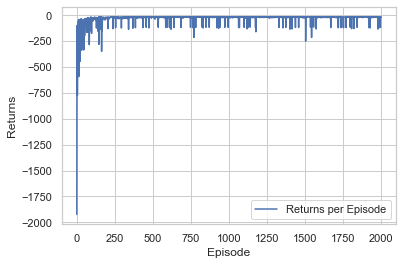

C:\Users\m-m20\AppData\Local\Temp\ipykernel_15712\2346382942.py:34: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(imgs[0] , ax=ax)


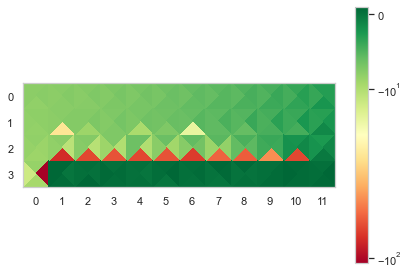

In [29]:
# Parameters for SARSA
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.1  # Exploration rate
num_episodes = 2000  # Number of episodes for training

# Function to choose an action using epsilon-greedy policy
def choose_action(state):
    if np.random.rand() < epsilon:
        return env.action_space.sample()  # Explore action space
    else:
        return np.argmax(random_q_table[state])  # Exploit learned values

# SARSA algorithm
random_q_table = np.random.random((obs_space.n, action_space.n))
returns_per_episode = []  # To store total rewards per episode

for episode in range(num_episodes):
    state, _ = env.reset()
    done = False
    total_rewards = 0
    action = choose_action(state)
    while not done:
        
        next_state, reward, done, truncated, info = env.step(action)
        next_action = choose_action(next_state)
        # SARSA update
        
        old_value = random_q_table[state, action]
        next_max = np.max(random_q_table[next_state])
        
        new_value = old_value + alpha * (reward + gamma * random_q_table[next_state, next_action] - old_value)
        random_q_table[state, action] = new_value

        total_rewards += reward
        state = next_state
        action = next_action
    
    returns_per_episode.append(total_rewards)


plot_returns_per_episode(returns_per_episode)

# Plot heatmap from our Q-table
q_vals_up = random_q_table[:, 0]
q_vals_right = random_q_table[:, 1]
q_vals_down = random_q_table[:, 2]
q_vals_left = random_q_table[:, 3]
create_qvals_heatmap(q_vals_up, q_vals_right, q_vals_down, q_vals_left)


# SARSA with boltzmann policy

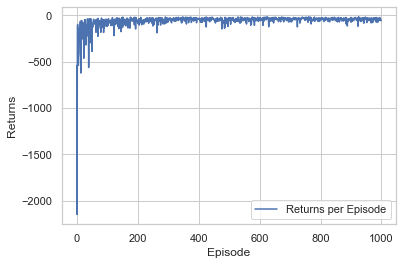

C:\Users\m-m20\AppData\Local\Temp\ipykernel_15712\2346382942.py:34: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(imgs[0] , ax=ax)


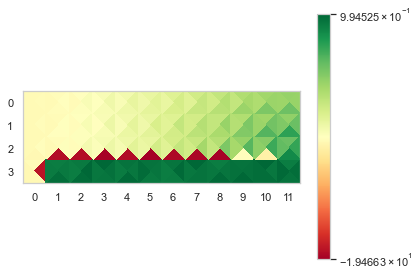

In [28]:
# Parameters for SARSA
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
num_episodes = 1000  # Number of episodes for training
temperature = 1  # Temperature for boltzmann policy

# Function to choose an action using boltzmann policy
def choose_action(state):
    q_values = random_q_table[state]
    probabilities = np.exp(q_values / temperature) / np.sum(np.exp(q_values / temperature))
    return np.random.choice(np.arange(len(q_values)), p=probabilities)
    

# SARSA algorithm
random_q_table = np.random.random((obs_space.n, action_space.n))
returns_per_episode = []  # To store total rewards per episode

for episode in range(num_episodes):
    state, _ = env.reset()
    done = False
    total_rewards = 0
    action = choose_action(state)
    while not done:
        
        next_state, reward, done, truncated, info = env.step(action)
        next_action = choose_action(next_state)
        # SARSA update
        
        old_value = random_q_table[state, action]
        next_max = np.max(random_q_table[next_state])
        
        new_value = old_value + alpha * (reward + gamma * random_q_table[next_state, next_action] - old_value)
        random_q_table[state, action] = new_value

        total_rewards += reward
        state = next_state
        action = next_action
    
    returns_per_episode.append(total_rewards)


plot_returns_per_episode(returns_per_episode)

# Plot heatmap from our Q-table
q_vals_up = random_q_table[:, 0]
q_vals_right = random_q_table[:, 1]
q_vals_down = random_q_table[:, 2]
q_vals_left = random_q_table[:, 3]
create_qvals_heatmap(q_vals_up, q_vals_right, q_vals_down, q_vals_left)
